In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import os
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Set Up Paths

In [3]:
BASE_PATH = "/content/drive/MyDrive/Work/Capstone_Organized" # CHANGE THIS WHEN YOU USE THE NOTEBOOK, ENSURE THE FINAL DESTINATION IS Capstone_Organized
INPUT_PATH = BASE_PATH + "/1-Data/ED_Model_Training_Dataset.csv"
LLM_ARTIFACT_PATH = BASE_PATH + "/3-Model_Training/3.2-LLM_Classification/3.2.0-FineTune_OpenBioLLM/"
os.makedirs(LLM_ARTIFACT_PATH, exist_ok=True)

OUTPUT_CHECKPOINT_PATH = os.path.join(LLM_ARTIFACT_PATH,"OpenBioLLM_Checkpoints")
OUTPUT_MODEL_PATH = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Final")
OFFLOAD_PATH = os.path.join(LLM_ARTIFACT_PATH, "offload")

MODEL_ID = "aaditya/Llama3-OpenBioLLM-8B"
TARGET_COLUMN = 'admitted'

### Import Dataset

In [4]:
# IMPORT DATA
df_full = pd.read_csv(INPUT_PATH)

print(f"Loaded {len(df_full)} rows.")
print("\n=====DataFrame Info=====")
df_full.info()

print("\n=====DataFrame Head=====")
display(df_full.head())

Loaded 4200 rows.

=====DataFrame Info=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    4200 non-null   int64  
 1   sex                    4200 non-null   object 
 2   triage_notes           4200 non-null   object 
 3   heart_rate             4200 non-null   int64  
 4   bp_systolic            4200 non-null   int64  
 5   bp_diastolic           4200 non-null   int64  
 6   resp_rate              4200 non-null   int64  
 7   temperature_C          4200 non-null   float64
 8   oxygen_saturation      4200 non-null   float64
 9   ESI                    4200 non-null   int64  
 10  recent_admissions_30d  4200 non-null   int64  
 11  admitted               4200 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 393.9+ KB

=====DataFrame Head=====


,age,sex,triage_notes,heart_rate,bp_systolic,bp_diastolic,resp_rate,temperature_C,oxygen_saturation,ESI,recent_admissions_30d,admitted
0,67,M,67-year-old male presents with fever for 2 hou...,148,182,67,29,37.8,94.0,5,0,1
1,74,M,74-year-old male presents with dizziness for 3...,96,176,75,29,36.7,89.0,3,0,1
2,3,M,3-year-old male presents with headache for 6 h...,89,146,97,26,37.8,88.0,4,0,1
3,28,M,28-year-old male presents with dizziness for 2...,147,156,90,13,35.9,85.0,1,0,1
4,19,M,19-year-old male presents with chest pain for ...,65,187,77,22,39.9,91.0,3,0,0


### Preprocessing Data

In [5]:
# PII MASKING: age

def bucket_age(a):
    """Bins the age column into categorical ranges."""
    if pd.isna(a): return None
    a = int(a)
    if a <= 17: return "0-17"
    if a <= 34: return "18-34"
    if a <= 49: return "35-49"
    if a <= 64: return "50-64"
    return "65+"

df_full["age_bucket"] = df_full["age"].apply(bucket_age)

In [6]:
# PII MASKING: triage_notes

EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE  = re.compile(r"\b(?:\+?1[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}\b")
SSN_RE    = re.compile(r"\b\d{3}-?\d{2}-?\d{4}\b")
DATE_RE   = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b")

# Normalize unicode dashes to ASCII hyphen
DASHES = dict.fromkeys(map(ord, "\u2010\u2011\u2012\u2013\u2014\u2015"), "-")

AGE_PATTERNS = [
    re.compile(r"\b(\d{1,3})\W*(?:year|yrs?|yo|y\/?o)\W*(?:old|of\s+age)?\b", re.IGNORECASE), # Catch X-year-old, X y/o, X yrs, etc.
    re.compile(r"\bage[d]?\s*(\d{1,3})\b", re.IGNORECASE), # Catch aged X / age X
    re.compile(r"\b(in\s+(?:his|her|their|a|the)\s+)\d{2}s\b", re.IGNORECASE) # Catching decades (in his 40s)
]

# Gendered words/titles and pronouns
GENDER_RE   = re.compile(r"\b(male|female|man|woman|boy|girl|gentleman|lady|mr\.?|mrs\.?|ms\.?)\b", re.IGNORECASE)
PRONOUN_RE  = re.compile(r"\b(he|she|him|her|his|hers)\b", re.IGNORECASE)
_PRONOUN_MAP = {'he':'they','she':'they','him':'them','her':'them','his':'their','hers':'their'}

def _neutralize_pronouns(text: str) -> str:
    def _sub(m):
        src = m.group(1)
        repl = _PRONOUN_MAP[src.lower()]
        if src.isupper():     return repl.upper()
        if src[0].isupper():  return repl.capitalize()
        return repl
    return PRONOUN_RE.sub(_sub, text)

def _remove_age(m):
    """Removes the entire matched age phrase."""
    return ""

def redact_text(s):
    """Redact PII + demographics; REMOVES all numeric ages."""
    if pd.isna(s):
        return None
    t = str(s).translate(DASHES)

    # PII
    t = EMAIL_RE.sub("[EMAIL]", t)
    t = PHONE_RE.sub("[PHONE]", t)
    t = SSN_RE.sub("[SSN]", t)
    t = DATE_RE.sub("[DATE]", t)

    # Ages → REMOVE (using the aggressive patterns above)
    for rx in AGE_PATTERNS:
        # This replaces the entire matched phrase (e.g., "67-year-old") with "[AGE]"
        t = rx.sub(_remove_age, t)

    # Gendered terms and pronouns
    t = GENDER_RE.sub("the patient", t)
    t = _neutralize_pronouns(t)

    return re.sub(r"\s+", " ", t).strip()

df_full["triage_notes_redacted"] = df_full["triage_notes"].apply(redact_text)
test_note_redacted = df_full["triage_notes_redacted"].iloc[0]
print("\nOriginal Note:")
print(test_note_redacted)


Original Note:
the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.


In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    4200 non-null   int64  
 1   sex                    4200 non-null   object 
 2   triage_notes           4200 non-null   object 
 3   heart_rate             4200 non-null   int64  
 4   bp_systolic            4200 non-null   int64  
 5   bp_diastolic           4200 non-null   int64  
 6   resp_rate              4200 non-null   int64  
 7   temperature_C          4200 non-null   float64
 8   oxygen_saturation      4200 non-null   float64
 9   ESI                    4200 non-null   int64  
 10  recent_admissions_30d  4200 non-null   int64  
 11  admitted               4200 non-null   int64  
 12  age_bucket             4200 non-null   object 
 13  triage_notes_redacted  4200 non-null   object 
dtypes: float64(2), int64(8), object(4)
memory usage: 459.5+ 

In [8]:
# BLEND ALL COLUMNS INTO ONE STRING OF TEXT

def format_for_llm(row):
    return (
        f"age range: {(row['age_bucket'])} / "
        f"sex: {row['sex']} / "
        f"heart rate: {row['heart_rate']} / "
        f"systolic blood pressure: {row['bp_systolic']} / "
        f"diastolic blood pressure: {row['bp_diastolic']} / "
        f"respiratory rate: {row['resp_rate']} / "
        f"temperature in Celsius: {row['temperature_C']} / "
        f"oxygen saturation: {row['oxygen_saturation']} / "
        f"ESI: {int(row['ESI'])} / "
        f"recent admissions (in 30 days): {int(row['recent_admissions_30d'])} / "
        f"{row['triage_notes_redacted']}"
    )

df_full["formatted_text"] = df_full.apply(format_for_llm, axis=1)

df_llm = df_full[["formatted_text", TARGET_COLUMN]].copy()
df_llm = df_llm.rename(columns={'formatted_text': 'text', TARGET_COLUMN: 'labels'})

display(df_llm.head())

,text,labels
0,age range: 65+ / sex: M / heart rate: 148 / sy...,1
1,age range: 65+ / sex: M / heart rate: 96 / sys...,1
2,age range: 0-17 / sex: M / heart rate: 89 / sy...,1
3,age range: 18-34 / sex: M / heart rate: 147 / ...,1
4,age range: 18-34 / sex: M / heart rate: 65 / s...,0


In [9]:
# SPLIT DATA
train_df, val_df = train_test_split(
    df_llm,
    test_size=0.2,
    random_state=14,
    stratify=df_llm['labels']
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))

In [10]:
# LOAD TOKENIZER

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
# TOKENIZE DATASETS

def preprocess_function(batch):
    toks = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    return {
        "input_ids": toks["input_ids"],
        "attention_mask": toks["attention_mask"],
    }

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

train_ds.set_format("torch")
val_ds.set_format("torch")

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

### Model Training

In [12]:
# COMPUTE CLASS WEIGHTS FOR TRAINING SET

train_labels_int = [example['labels'].item() for example in train_ds]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_int),
    y=train_labels_int
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Computed class weights (for classes 0 and 1): {class_weights_tensor}")

Computed class weights (for classes 0 and 1): tensor([0.7192, 1.6406], device='cuda:0')


In [13]:
# CREATE CUSTOM WEIGHTED TRAINER

from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    """
    A custom Trainer that applies class weights to the loss function.
    """
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0): # Added num_items_in_batch
        labels = inputs.pop("labels")

        # Get model outputs
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # --- Apply weights ---
        # Initialize the loss function *with our weights*
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)

        # Compute the weighted loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [14]:
# LOAD BASE MODEL

base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto",
    offload_folder=OFFLOAD_PATH
)

if base_model.config.pad_token_id is None:
    base_model.config.pad_token_id = tokenizer.pad_token_id

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# LORA CONFIGURATION

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(base_model, lora_config)

model.enable_input_require_grads()

model.print_trainable_parameters()

trainable params: 13,639,680 || all params: 7,518,572,544 || trainable%: 0.1814


In [16]:
# SET TRAINING ARGUMENTS

BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 4

training_args = TrainingArguments(
    output_dir=OUTPUT_CHECKPOINT_PATH,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=10,
    learning_rate=5e-6,
    weight_decay=0.01,
    warmup_ratio=0.1,
    optim="adamw_torch",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_auc", # Focus on AUC
    greater_is_better=True,
    report_to="none",
    fp16=True,
    label_names=['labels'],
    dataloader_pin_memory=False,
    gradient_checkpointing=True,
)

In [17]:
# SET COMPUTE METRICS

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)

    # Calculate probs for AUC
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    auc_score = roc_auc_score(labels, probs[:, 1])

    # Confusion Matrix
    tn, fp, fn, tp = 0, 0, 0, 0 # Default values
    try:
        cm = confusion_matrix(labels, predictions)
        if cm.size == 4: # Ensure it's a 2x2 matrix
            tn, fp, fn, tp = cm.ravel()
        else:
            if len(np.unique(labels)) > 1: pass
            elif np.unique(labels)[0] == 0: tn = cm[0][0]
            elif np.unique(labels)[0] == 1: tp = cm[0][0]
    except ValueError:
        pass # Handle case where only one class is predicted

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "accuracy": acc,
        "precision": precision,
        "recall/sensitivity": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc_score,
        "true_positives": tp,
        "false_positives": fp,
        "true_negatives": tn,
        "false_negatives": fn
    }

In [18]:
# INITIALIZE TRAINER

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = CustomTrainer(  # <-- Using our CustomTrainer
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/tmp/ipython-input-3528223656.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(  # <-- Using our CustomTrainer
The model is already on multiple devices. Skipping the move to device specified in `args`.


In [19]:
# TRAIN

trainer.train()
trainer.save_model(OUTPUT_MODEL_PATH)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall/sensitivity,Specificity,F1,Auc,True Positives,False Positives,True Negatives,False Negatives
1,3.254600,0.821971,0.607143,0.343220,0.316406,0.734589,0.329268,0.534996,81,155,429,175
2,3.306200,0.807538,0.445238,0.294118,0.585938,0.383562,0.391645,0.507749,150,360,224,106
3,2.857100,0.756010,0.630952,0.353261,0.253906,0.796233,0.295455,0.528009,65,119,465,191


### Model Evaluation


--- Final Model Evaluation Metrics (at 0.5 threshold) ---
{
  "eval_loss": 0.8219712972640991,
  "eval_accuracy": 0.6071428571428571,
  "eval_precision": 0.3432203389830508,
  "eval_recall/sensitivity": 0.31640625,
  "eval_specificity": 0.7345890410958904,
  "eval_f1": 0.32926829268292684,
  "eval_auc": 0.5349957191780822,
  "eval_true_positives": 81,
  "eval_false_positives": 155,
  "eval_true_negatives": 429,
  "eval_false_negatives": 175,
  "eval_runtime": 13.584,
  "eval_samples_per_second": 61.838,
  "eval_steps_per_second": 7.73,
  "epoch": 3.0
}

Generating ROC Curve and Threshold Analysis...


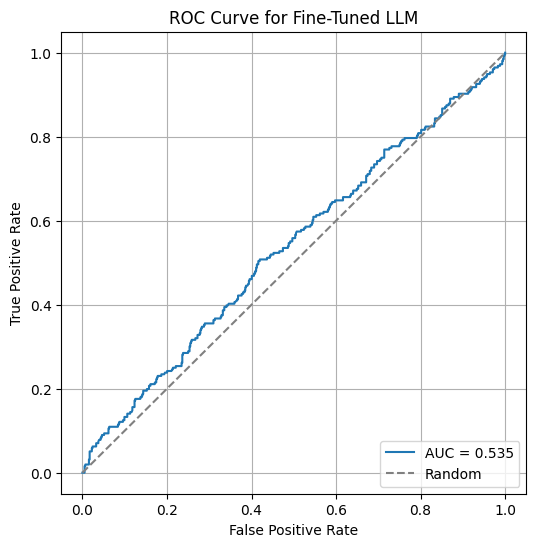


Metrics at Different Thresholds:
 threshold  accuracy  precision  recall     f1
    0.0000    0.3048     0.3048  1.0000 0.4672
    0.0500    0.3060     0.3013  0.9688 0.4597
    0.1000    0.3286     0.3031  0.9258 0.4566
    0.1500    0.3631     0.3071  0.8672 0.4535
    0.2000    0.3929     0.3082  0.7969 0.4444
    0.2500    0.4393     0.3169  0.7266 0.4413
    0.3000    0.4738     0.3205  0.6484 0.4289
    0.3500    0.5167     0.3311  0.5742 0.4200
    0.4000    0.5583     0.3433  0.4922 0.4045
    0.4500    0.5810     0.3356  0.3828 0.3577
    0.5000    0.6060     0.3418  0.3164 0.3286
    0.5500    0.6179     0.3316  0.2500 0.2851
    0.6000    0.6405     0.3544  0.2188 0.2705
    0.6500    0.6607     0.3670  0.1562 0.2192
    0.7000    0.6702     0.3704  0.1172 0.1780
    0.7500    0.6893     0.4510  0.0898 0.1498
    0.8000    0.6940     0.4865  0.0703 0.1229
    0.8500    0.6988     0.5652  0.0508 0.0932
    0.9000    0.6917     0.3846  0.0195 0.0372
    0.9500    0.6964     0

In [20]:
metrics = trainer.evaluate()

print("\n--- Final Model Evaluation Metrics (at 0.5 threshold) ---")
print(json.dumps(metrics, indent=2))

# --- ROC/AUC Analysis ---
print("\nGenerating ROC Curve and Threshold Analysis...")
pred_out = trainer.predict(val_ds)
logits = pred_out.predictions
labels = pred_out.label_ids

# Convert logits -> probabilities
exp = np.exp(logits)
probs = exp[:, 1] / exp.sum(axis=1)

# Compute ROC curve & AUC
fpr, tpr, roc_thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fine-Tuned LLM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Sweep thresholds
print("\nMetrics at Different Thresholds:")
thresholds = np.linspace(0.0, 1.0, 21)
rows = []
for thr in thresholds:
    preds = (probs >= thr).astype(int)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    rows.append({'threshold': thr, 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1})

thresh_df = pd.DataFrame(rows)
print(thresh_df.to_string(index=False, float_format="%.4f"))
print("\n--- LLM RETRAINING PIPELINE COMPLETE ---")